In [3]:
pip install scikit-image

   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ------------------------- -------------- 8.1/12.9 MB 41.8 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 38.4 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 38.4 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 38.4 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 38.4 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 38.4 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 38.4 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 38.4 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 38.4 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 38.4 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 38.4 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 38.4 

In [2]:
pip install opencv-contrib-python


   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---- ----------------------------------- 4.7/46.2 MB 23.7 MB/s eta 0:00:02
   --------- ------------------------------ 10.7/46.2 MB 26.8 MB/s eta 0:00:02
   ------------- -------------------------- 16.0/46.2 MB 26.5 MB/s eta 0:00:02
   --------------- ------------------------ 18.1/46.2 MB 22.8 MB/s eta 0:00:02
   ---------------- ----------------------- 18.9/46.2 MB 18.9 MB/s eta 0:00:02
   ----------------- ---------------------- 20.4/46.2 MB 17.2 MB/s eta 0:00:02
   ------------------- -------------------- 22.8/46.2 MB 15.9 MB/s eta 0:00:02
   ------------------------ --------------- 28.3/46.2 MB 17.3 MB/s eta 0:00:02
   ----------------------------- ---------- 34.6/46.2 MB 18.8 MB/s eta 0:00:01
   ---------------------------------- ----- 40.1/46.2 MB 19.6 MB/s eta 0:00:01
   -------------------------------------- - 44.8/46.2 MB 19.9 MB/s eta 0:00:01
   ---------------------------------------  46.1/46.2 MB 19.3 

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import hog, graycomatrix, graycoprops
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ----------- Feature Extraction Functions ----------- #

def extract_sift_features(image):
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image, None)
    if des is None:
        return np.zeros(128)  # If no keypoints, return zeros
    return np.mean(des, axis=0)[:128]  # Use mean to reduce dimensionality

def extract_hog_features(image):
    return hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

def extract_glcm_features(image):
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return np.array([
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'dissimilarity')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'energy')[0, 0]
    ])

def extract_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Unable to read {image_path}")
        return None
    image = cv2.resize(image, (128, 128))

    sift_feat = extract_sift_features(image)
    hog_feat = extract_hog_features(image)
    glcm_feat = extract_glcm_features(image)

    return np.hstack((sift_feat, hog_feat, glcm_feat))

# ----------- Load Dataset ----------- #

def load_dataset(dataset_path):
    X, y = [], []
    labels = {"cats": 0, "dogs": 1}  # Match folder names
    for category in ["cats", "dogs"]:
        folder = os.path.join(dataset_path, category)
        for filename in os.listdir(folder):
            image_path = os.path.join(folder, filename)
            features = extract_features(image_path)
            if features is not None:
                X.append(features)
                y.append(labels[category])
    return np.array(X), np.array(y)

# ----------- Train SVM Model ----------- #

def train_svm(X, y):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    pca = PCA(n_components=100)
    X = pca.fit_transform(X)

    smote = SMOTE()
    X, y = smote.fit_resample(X, y)

    param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    return best_model, scaler, pca

# ----------- Classify a New Image ----------- #

def classify_image(model, scaler, pca, image_path):
    features = extract_features(image_path)
    if features is None:
        return "Error: Invalid image"
    
    features = scaler.transform([features])
    features = pca.transform(features)
    prediction = model.predict(features)[0]
    
    return "Dog" if prediction == 1 else "Cat"

# ----------- Main Execution ----------- #

dataset_path = r"D:\test_set"  # Change to your dataset path
X, y = load_dataset(dataset_path)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_classifier, scaler, pca = train_svm(X_train, y_train)

# ----------- Evaluate the Model ----------- #
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)
y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Error: Unable to read D:\test_set\cats\_DS_Store
Error: Unable to read D:\test_set\dogs\_DS_Store
Test Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.70      0.74       209
           1       0.71      0.78      0.74       196

    accuracy                           0.74       405
   macro avg       0.74      0.74      0.74       405
weighted avg       0.74      0.74      0.74       405

Confusion Matrix:
 [[147  62]
 [ 43 153]]


In [5]:
image_path = r"D:\test_set\cats\cat.4012.jpg"  # Change to test image path
result = classify_image(svm_classifier, scaler, pca, image_path)
print(f"Prediction for {image_path}: {result}")

Prediction for D:\test_set\cats\cat.4012.jpg: Cat


In [6]:
image_path = r"D:\test_set\dogs\dog.4025.jpg"  # Change to test image path
result = classify_image(svm_classifier, scaler, pca, image_path)
print(f"Prediction for {image_path}: {result}")

Prediction for D:\test_set\dogs\dog.4025.jpg: Dog


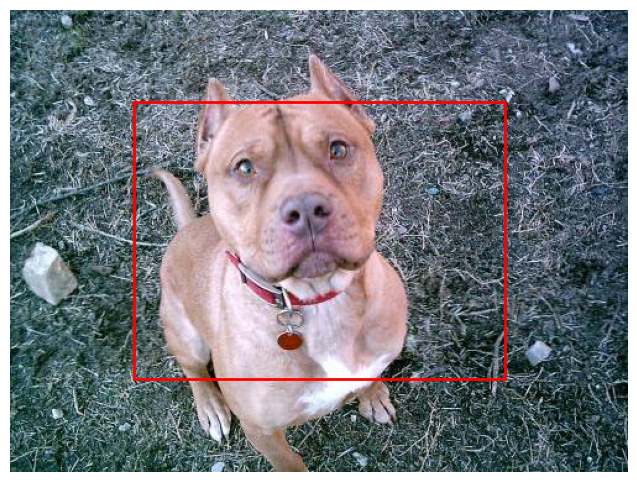

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_features_from_patch(patch):
   
    sift_feat = extract_sift_features(patch)
    hog_feat = extract_hog_features(patch)
    glcm_feat = extract_glcm_features(patch)
    return np.hstack((sift_feat, hog_feat, glcm_feat))

def detect_and_classify_svm(model, scaler, pca, image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read {image_path}")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize to fixed dimensions for classification
    resized_img = cv2.resize(gray, (128, 128))
    features = extract_features_from_patch(resized_img)

    # Preprocess features for SVM
    features = scaler.transform([features])
    features = pca.transform(features)
    
    prediction = model.predict(features)[0]

    # Define a bounding box covering most of the object
    h, w = image.shape[:2]
    box_x, box_y = int(w * 0.2), int(h * 0.2)  # Offset from edges
    box_w, box_h = int(w * 0.6), int(h * 0.6)  # Central bounding box

    # Convert image to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot using Matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(image_rgb)

    # Draw bounding box
    color = "blue" if prediction == 0 else "red"  # Blue for Cat, Red for Dog
    rect = plt.Rectangle((box_x, box_y), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

    plt.axis("off")  # Hide axes
    plt.show()

# ----------- Test on Your Uploaded Image ----------- #
image_path = r"D:\test_set\dogs\dog.4025.jpg" 
detect_and_classify_svm(svm_classifier, scaler, pca, image_path)


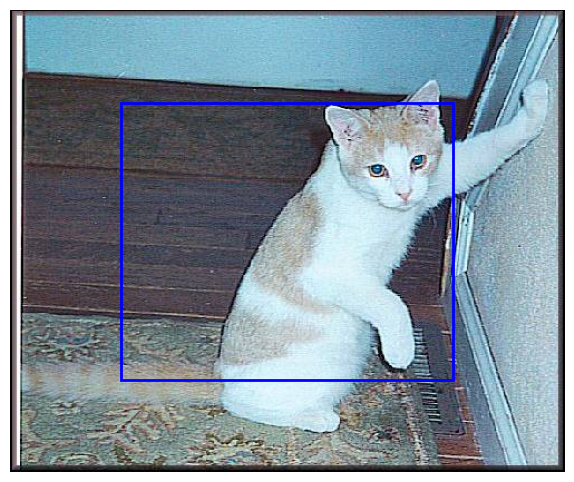

In [33]:
image_path = r"D:\test_set\cats\cat.4001.jpg"
detect_and_classify_svm(svm_classifier, scaler, pca, image_path)

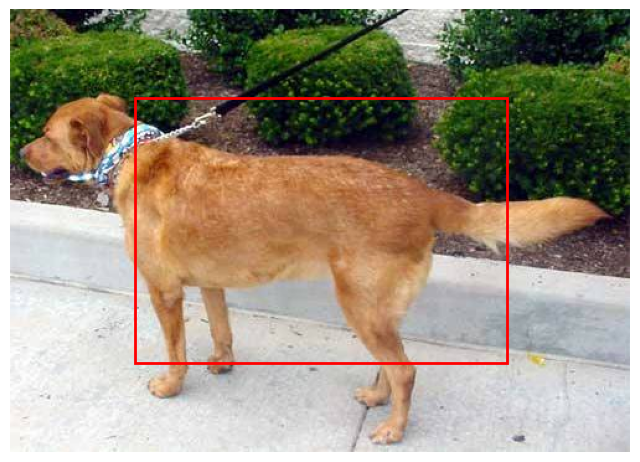

In [34]:
image_path = r"D:\test_set\dogs\dog.4011.jpg"
detect_and_classify_svm(svm_classifier, scaler, pca, image_path)

In [9]:
!pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25857 sha256=4fb24c9539f0e7ebe60d112210498f5443a38fedd76abff3c7c1f9ef76534ee0
  Stored in directory: c:\users\nabil\appdata\local\pip\cache\wheels\5b\76\96\ad0c321506837bef578cf3008df3916c23018435a355d9f6b1
Successfully built imutils


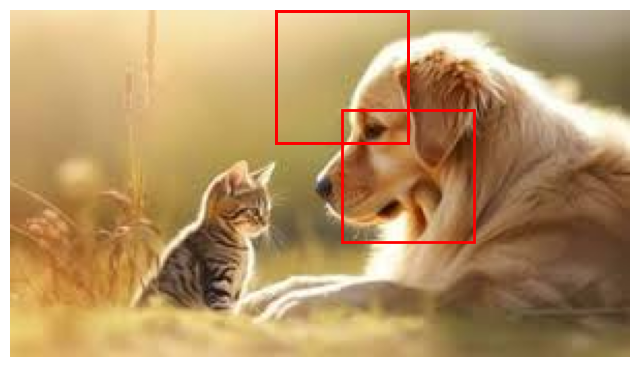

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imutils.object_detection import non_max_suppression

def sliding_window(image, step_size, window_size):
    """Generate sliding windows over the image."""
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def detect_objects(image_path, model, scaler, pca, window_size=(64, 64), step_size=16, threshold=0.2):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read {image_path}")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    boxes = []
    labels = []
    scores = []

    for (x, y, window) in sliding_window(gray, step_size, window_size):
        if window.shape[:2] != window_size:  # Ensure correct window size
            continue  

        window_resized = cv2.resize(window, (128, 128))
        features = extract_features_from_patch(window_resized)

        features = scaler.transform([features])
        features = pca.transform(features)
        prediction = model.predict(features)[0]
        confidence = model.decision_function(features)[0]  # Get confidence score

        if confidence > threshold:
            boxes.append([x, y, x + window_size[0], y + window_size[1]])  # Ensure format is [x1, y1, x2, y2]
            labels.append("cat" if prediction == 0 else "dog")
            scores.append(confidence)

    # Convert to numpy array
    boxes = np.array(boxes)
    scores = np.array(scores)

    # Apply non-max suppression only if there are detected boxes
    final_boxes, final_labels = [], []
    if len(boxes) > 0:
        indices = non_max_suppression(boxes, probs=scores, overlapThresh=0.3)
        
        if indices is not None and len(indices) > 0:
            indices = indices.flatten()  # Convert to list of indices
            valid_indices = [int(i) for i in indices if i < len(boxes)]  # Ensure valid indices
            
            final_boxes = [boxes[i].tolist() for i in valid_indices]
            final_labels = [labels[i] for i in valid_indices]

    draw_boxes(image, final_boxes, final_labels)

def extract_features_from_patch(patch):
    patch = cv2.resize(patch, (128, 128))
    sift_feat = extract_sift_features(patch)
    hog_feat = extract_hog_features(patch)
    glcm_feat = extract_glcm_features(patch)
    return np.hstack((sift_feat, hog_feat, glcm_feat))

def draw_boxes(image, boxes, labels):
    """Draw bounding boxes on the image."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(image_rgb)

    for (x1, y1, x2, y2), label in zip(boxes, labels):
        color = "blue" if label == "cat" else "red"
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()

# Example usage
detect_objects(r"D:\images.jpg", svm_classifier, scaler, pca)


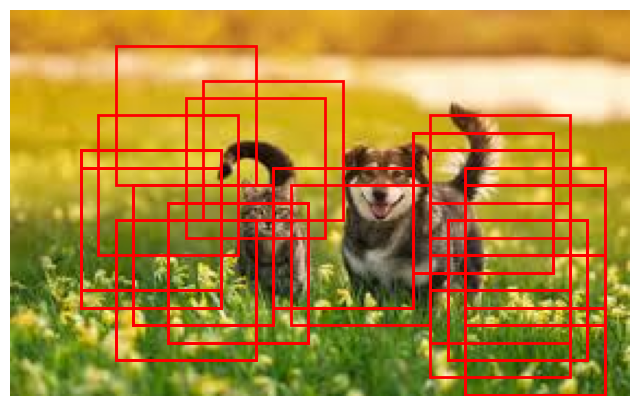

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression

def sliding_window(image, step_size, window_size):
    """Generate sliding windows over the image."""
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def detect_objects(image_path, model, scaler, pca, window_size=(64, 64), step_size=8, threshold=0.3):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read {image_path}")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    boxes, labels, scores = [], [], []

    for (x, y, window) in sliding_window(gray, step_size, window_size):
        if window.shape[:2] != window_size:  
            continue  

        window_resized = cv2.resize(window, (128, 128))
        features = extract_features_from_patch(window_resized)
        features = scaler.transform([features])
        features = pca.transform(features)
        
        prediction = model.predict(features)[0]
        confidence = model.decision_function(features)[0]

       

        if confidence > threshold:
            boxes.append([x, y, x + window_size[0], y + window_size[1]])
            labels.append("cat" if prediction == 0 else "dog")
            scores.append(confidence)

    if len(boxes) == 0:
        print("No objects detected!")

    # Apply Non-Max Suppression
    boxes, scores = np.array(boxes), np.array(scores)
    final_boxes, final_labels = [], []

    if len(boxes) > 0:
        indices = non_max_suppression(boxes, probs=scores, overlapThresh=0.4)
        indices = indices.flatten()
        
        for i in indices:
            if i < len(boxes) and i < len(labels):
                final_boxes.append(boxes[i].tolist())
                final_labels.append(labels[i])

    draw_boxes(image, final_boxes, final_labels)

def extract_features_from_patch(patch):
    patch = cv2.resize(patch, (128, 128))
    sift_feat = extract_sift_features(patch)
    hog_feat = extract_hog_features(patch)
    glcm_feat = extract_glcm_features(patch)
    
  
    
    return np.hstack((sift_feat, hog_feat, glcm_feat))

def draw_boxes(image, boxes, labels):
    """Draw bounding boxes on the image."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(image_rgb)

    for (x1, y1, x2, y2), label in zip(boxes, labels):
        color = "blue" if label == "cat" else "red"
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()

# Example usage
detect_objects(r"D:\images (2).jpg", svm_classifier, scaler, pca)


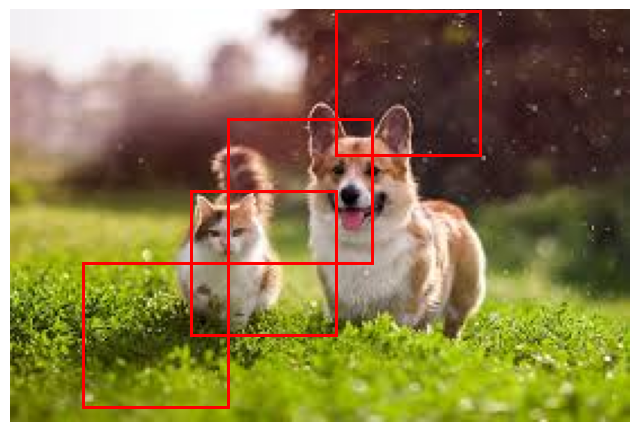

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imutils.object_detection import non_max_suppression

def sliding_window(image, step_size, window_size):
    """Generate sliding windows over the image."""
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def detect_objects(image_path, model, scaler, pca, window_size=(64, 64), step_size=16, threshold=0.3):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read {image_path}")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    boxes = []
    labels = []
    scores = []

    for (x, y, window) in sliding_window(gray, step_size, window_size):
        if window.shape[:2] != window_size:  # Ensure correct window size
            continue  

        window_resized = cv2.resize(window, (128, 128))
        features = extract_features_from_patch(window_resized)

        features = scaler.transform([features])
        features = pca.transform(features)
        prediction = model.predict(features)[0]
        confidence = model.decision_function(features)[0]  # Get confidence score

        if confidence > 0.2:  # Increased threshold to reduce false positives
            boxes.append([x, y, x + window_size[0], y + window_size[1]])  # Ensure format is [x1, y1, x2, y2]
            labels.append("cat" if prediction == 0 else "dog")
            scores.append(confidence)

    # Convert to numpy array
    boxes = np.array(boxes)
    scores = np.array(scores)

    # Apply non-max suppression only if there are detected boxes
    final_boxes, final_labels = [], []
    if len(boxes) > 0:
        indices = non_max_suppression(boxes, probs=scores, overlapThresh=0.7)  # Increased threshold
        
        if indices is not None and len(indices) > 0:
            indices = indices.flatten()  # Convert to list of indices
            valid_indices = [int(i) for i in indices if i < len(boxes)]  # Ensure valid indices
            
            final_boxes = [boxes[i].tolist() for i in valid_indices]
            final_labels = [labels[i] for i in valid_indices]

    draw_boxes(image, final_boxes, final_labels)

def extract_features_from_patch(patch):
    patch = cv2.resize(patch, (128, 128))
    sift_feat = extract_sift_features(patch)
    hog_feat = extract_hog_features(patch)
    glcm_feat = extract_glcm_features(patch)
    return np.hstack((sift_feat, hog_feat, glcm_feat))

def draw_boxes(image, boxes, labels):
    """Draw bounding boxes on the image."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(image_rgb)

    for (x1, y1, x2, y2), label in zip(boxes, labels):
        color = "blue" if label == "cat" else "red"
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()

# Example usage
detect_objects(r"D:\download.jpg", svm_classifier, scaler, pca)


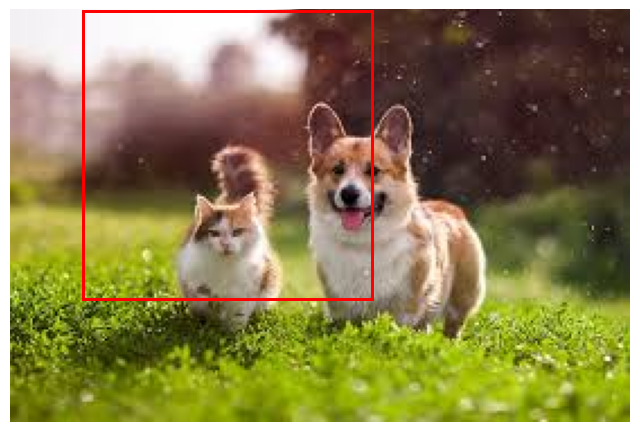

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imutils.object_detection import non_max_suppression

def sliding_window(image, step_size, window_size):
    """Generate sliding windows over the image."""
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def detect_objects(image_path, model, scaler, pca, window_size=(128, 128), step_size=32, threshold=0.4):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read {image_path}")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    boxes = []
    labels = []
    scores = []

    for (x, y, window) in sliding_window(gray, step_size, window_size):
        if window.shape[:2] != window_size:  # Ensure correct window size
            continue  

        window_resized = cv2.resize(window, (128, 128))
        features = extract_features_from_patch(window_resized)

        features = scaler.transform([features])
        features = pca.transform(features)
        prediction = model.predict(features)[0]
        confidence = model.decision_function(features)[0]  # Get confidence score

        if confidence > threshold:  # Increased threshold to reduce false positives
            boxes.append([x, y, x + window_size[0], y + window_size[1]])  # Format: [x1, y1, x2, y2]
            labels.append("cat" if prediction == 0 else "dog")
            scores.append(confidence)

    # Convert to numpy array
    boxes = np.array(boxes)
    scores = np.array(scores)

    # Apply non-max suppression only if there are detected boxes
    final_boxes, final_labels = [], []
    if len(boxes) > 0:
        indices = non_max_suppression(boxes, probs=scores, overlapThresh=0.4)  # Reduced threshold for better filtering
        
        if indices is not None and len(indices) > 0:
            indices = indices.flatten()  # Convert to list of indices
            valid_indices = [int(i) for i in indices if i < len(boxes)]  # Ensure valid indices
            
            final_boxes = [boxes[i].tolist() for i in valid_indices]
            final_labels = [labels[i] for i in valid_indices]

    draw_boxes(image, final_boxes, final_labels)

def extract_features_from_patch(patch):
    patch = cv2.resize(patch, (128, 128))
    sift_feat = extract_sift_features(patch)
    hog_feat = extract_hog_features(patch)
    glcm_feat = extract_glcm_features(patch)
    return np.hstack((sift_feat, hog_feat, glcm_feat))

def draw_boxes(image, boxes, labels):
    """Draw bounding boxes on the image."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(image_rgb)

    for (x1, y1, x2, y2), label in zip(boxes, labels):
        color = "blue" if label == "cat" else "red"
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()

# Example usage
detect_objects(r"D:\download.jpg", svm_classifier, scaler, pca)


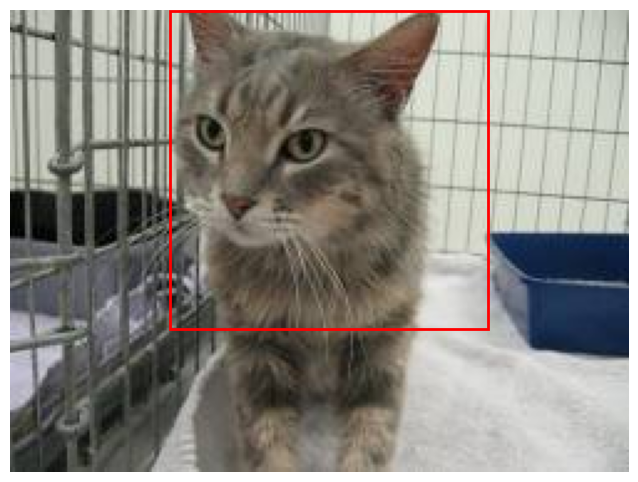

In [54]:
detect_objects(r"D:\test_set\cats\cat.4092.jpg", svm_classifier, scaler, pca)